# Circle Arrangements Demo

This notebook demonstrates the `circlesearch` library for studying
arrangements of circles in the affine plane ([OEIS A250001](https://oeis.org/A250001)).

In [11]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from circlesearch import Circle, Arrangement

## Creating Circles

A `Circle` is defined by its center `(x, y)` and radius `r`.

In [12]:
c1 = Circle(0, 0, 1)
c2 = Circle(1, 0, 1)

print(f"c1 = {c1}")
print(f"c2 = {c2}")
print(f"c1 intersects c2? {c1.intersects(c2)}")
print(f"Intersection points: {c1.intersection_points(c2)}")

c1 = Circle(x=0, y=0, r=1)
c2 = Circle(x=1, y=0, r=1)
c1 intersects c2? True
Intersection points: [(0.5, -0.8660254037844386), (0.5, 0.8660254037844386)]


## Plotting Helper

In [13]:
def plot_circles(circles, ax=None, title=""):
    """Plot a list of circles with intersection points."""
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    colors = plt.cm.tab10.colors

    for idx, c in enumerate(circles):
        theta = np.linspace(0, 2 * np.pi, 200)
        ax.plot(c.x + c.r * np.cos(theta),
                c.y + c.r * np.sin(theta),
                color=colors[idx % len(colors)],
                linewidth=2, label=f"Circle {idx}")

    for i in range(len(circles)):
        for j in range(i + 1, len(circles)):
            pts = circles[i].intersection_points(circles[j])
            for px, py in pts:
                ax.plot(px, py, 'ko', markersize=5)

    ax.set_aspect('equal')
    ax.legend(fontsize=8)
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    return ax

## The Three Arrangements of 2 Circles: $a(2) = 3$

1. **Disjoint** — side by side
2. **Overlapping** — Venn diagram
3. **Nested** — one inside the other

Disjoint: Arrangement(n_circles=2, vertices=0, edges=0, faces=3), nesting={0: None, 1: None}
Overlapping: Arrangement(n_circles=2, vertices=2, edges=4, faces=4), nesting={0: None, 1: None}
Nested: Arrangement(n_circles=2, vertices=0, edges=0, faces=3), nesting={0: None, 1: 0}


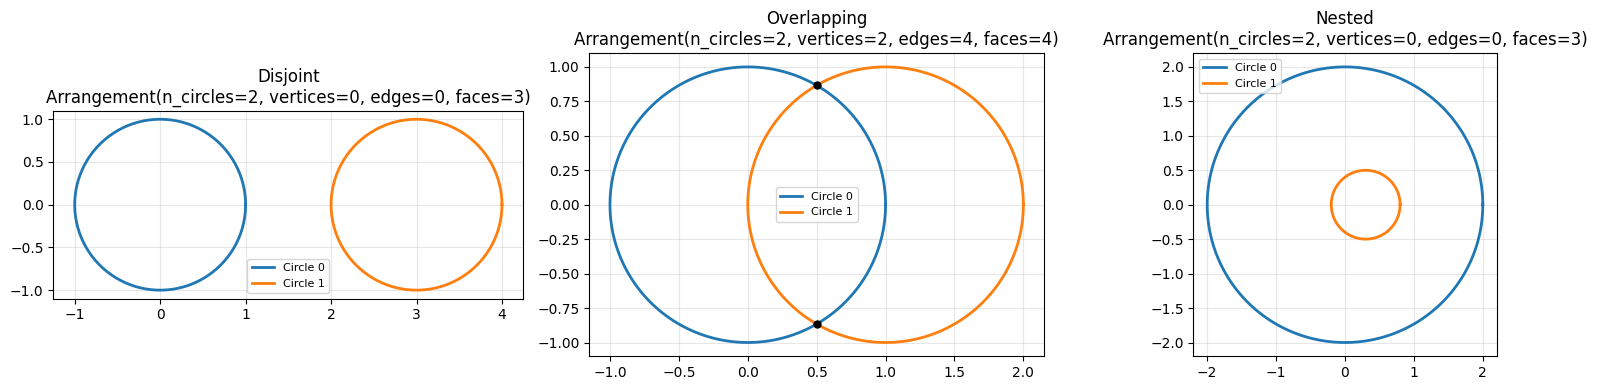

In [14]:
cases_n2 = {
    "Disjoint": [Circle(0, 0, 1), Circle(3, 0, 1)],
    "Overlapping": [Circle(0, 0, 1), Circle(1, 0, 1)],
    "Nested": [Circle(0, 0, 2), Circle(0.3, 0, 0.5)],
}

fig, axes = plt.subplots(1, 3, figsize=(16, 4))
for ax, (name, circles) in zip(axes, cases_n2.items()):
    arr = Arrangement.from_circles(circles)
    plot_circles(circles, ax=ax, title=f"{name}\n{arr}")
    print(f"{name}: {arr}, nesting={arr.nesting}")
plt.tight_layout()
plt.show()

## Building Arrangements and Inspecting Topology

The `Arrangement` class builds a planar map (as a `networkx.MultiGraph`)
from concrete circle placements. It tracks:
- **Vertices** (intersection points)
- **Edges** (arcs between consecutive intersection points on a circle)
- **Faces** (via Euler's formula)
- **Circle orders** (cyclic ordering of intersection points around each circle)
- **Nesting** (containment tree for non-intersecting circles)

Arrangement: Arrangement(n_circles=3, vertices=6, edges=12, faces=8)
Nesting: {0: None, 1: None, 2: None}

Intersection matrix:
  [False, True, True]
  [True, False, True]
  [True, True, False]

Circle orders (cyclic ordering of intersection points):
  Circle 0: [(0, 1, 0), (0, 2, 0), (0, 1, 1), (0, 2, 1)]
  Circle 1: [(1, 2, 1), (0, 1, 0), (1, 2, 0), (0, 1, 1)]
  Circle 2: [(1, 2, 1), (0, 2, 0), (1, 2, 0), (0, 2, 1)]


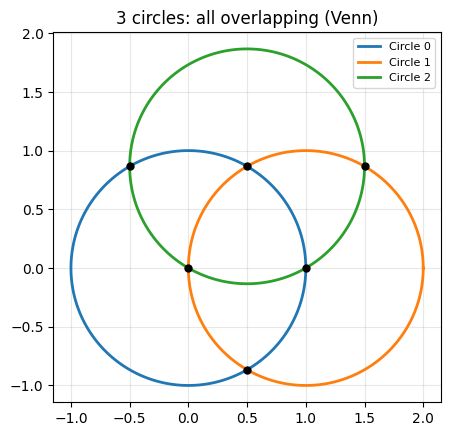

In [15]:
# Three mutually overlapping circles (classic Venn diagram)
circles_3 = [Circle(0, 0, 1), Circle(1, 0, 1), Circle(0.5, 0.866, 1)]
arr3 = Arrangement.from_circles(circles_3)

print(f"Arrangement: {arr3}")
print(f"Nesting: {arr3.nesting}")
print(f"\nIntersection matrix:")
for row in arr3.intersection_matrix():
    print(f"  {row}")
print(f"\nCircle orders (cyclic ordering of intersection points):")
for ci, order in arr3.circle_orders.items():
    print(f"  Circle {ci}: {order}")

plot_circles(circles_3, title="3 circles: all overlapping (Venn)")
plt.show()

## Equivalence Checking

Two arrangements are equivalent if their planar maps are isomorphic
(up to relabeling circles and reflection). `is_isomorphic_to` checks:
1. Graph isomorphism of the arrangement multigraph
2. Consistency of cyclic orderings around each circle
3. Isomorphism of the nesting tree (for non-intersecting circles)

In [16]:
# Two different placements of overlapping circles -> same arrangement
arr_a = Arrangement.from_circles([Circle(0, 0, 1), Circle(1, 0, 1)])
arr_b = Arrangement.from_circles([Circle(5, 5, 2), Circle(6, 5, 2)])
print(f"Same topology (overlapping): {arr_a.is_isomorphic_to(arr_b)}")

# All three n=2 types are distinct
arr_disjoint = Arrangement.from_circles([Circle(0, 0, 1), Circle(5, 0, 1)])
arr_nested = Arrangement.from_circles([Circle(0, 0, 2), Circle(0, 0, 0.5)])
print(f"Overlapping vs disjoint: {arr_a.is_isomorphic_to(arr_disjoint)}")
print(f"Overlapping vs nested:   {arr_a.is_isomorphic_to(arr_nested)}")
print(f"Disjoint vs nested:      {arr_disjoint.is_isomorphic_to(arr_nested)}")

Same topology (overlapping): True
Overlapping vs disjoint: False
Overlapping vs nested:   False
Disjoint vs nested:      False


## Face Counts via Euler's Formula

For a connected planar graph: $V - E + F = 2$.
For disconnected: $V - E + F = 1 + C$ where $C$ = connected components.
Isolated circles each add one bounded face.

In [17]:
test_cases = [
    ("0 circles", []),
    ("1 circle", [Circle(0, 0, 1)]),
    ("2 disjoint", [Circle(0, 0, 1), Circle(3, 0, 1)]),
    ("2 overlapping", [Circle(0, 0, 1), Circle(1, 0, 1)]),
    ("2 nested", [Circle(0, 0, 2), Circle(0, 0, 0.5)]),
    ("3 Venn", [Circle(0, 0, 1), Circle(1, 0, 1), Circle(0.5, 0.866, 1)]),
    ("3 chain", [Circle(0, 0, 1), Circle(1.5, 0, 1), Circle(3, 0, 1)]),
]

print(f"{'Config':<16} {'V':>3} {'E':>3} {'F':>3}  V-E+F")
print("-" * 38)
for name, circles in test_cases:
    arr = Arrangement.from_circles(circles)
    euler = arr.n_vertices - arr.n_edges + arr.n_faces
    print(f"{name:<16} {arr.n_vertices:>3} {arr.n_edges:>3} {arr.n_faces:>3}  {euler}")

Config             V   E   F  V-E+F
--------------------------------------
0 circles          0   0   1  1
1 circle           0   0   2  2
2 disjoint         0   0   3  3
2 overlapping      2   4   4  2
2 nested           0   0   3  3
3 Venn             6  12   8  2
3 chain            4   8   6  2


## Arrangement Graph Visualization

The arrangement graph has intersection points as nodes and circle arcs
as edges (colored by which circle they belong to).

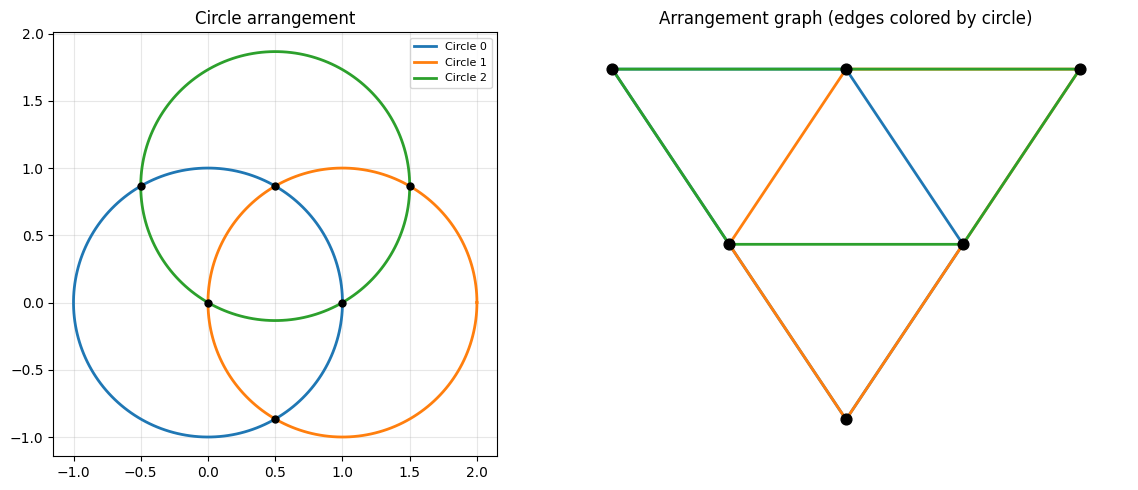

In [18]:
circles_3 = [Circle(0, 0, 1), Circle(1, 0, 1), Circle(0.5, 0.866, 1)]
arr = Arrangement.from_circles(circles_3)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Left: geometric circles
plot_circles(circles_3, ax=ax1, title="Circle arrangement")

# Right: arrangement graph
pos = nx.get_node_attributes(arr.graph, 'pos')
colors = plt.cm.tab10.colors
edge_colors = [colors[d['circle']] for _, _, d in arr.graph.edges(data=True)]
nx.draw(arr.graph, pos=pos, ax=ax2, with_labels=False,
        node_size=60, node_color='black',
        edge_color=edge_colors, width=2)
ax2.set_title('Arrangement graph (edges colored by circle)')

plt.tight_layout()
plt.show()

## Nesting Structure

For non-intersecting circles, the **nesting tree** records which circle
is inside which. This is essential for distinguishing arrangements like
"disjoint" vs "nested".

Arrangement: Arrangement(n_circles=3, vertices=0, edges=0, faces=4)
Nesting: {0: None, 1: 0, 2: 0}
  Circle 0 (big): parent = None (outermost)
  Circle 1 (left small): parent = 0
  Circle 2 (right small): parent = 0


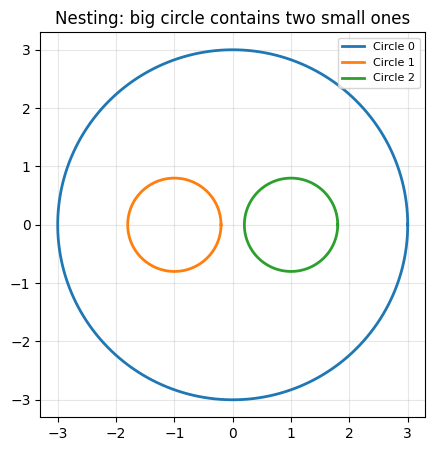

In [19]:
# Three circles: big contains two small disjoint ones
nested_3 = [Circle(0, 0, 3), Circle(-1, 0, 0.8), Circle(1, 0, 0.8)]
arr_n3 = Arrangement.from_circles(nested_3)
print(f"Arrangement: {arr_n3}")
print(f"Nesting: {arr_n3.nesting}")
print("  Circle 0 (big): parent = None (outermost)")
print(f"  Circle 1 (left small): parent = {arr_n3.nesting[1]}")
print(f"  Circle 2 (right small): parent = {arr_n3.nesting[2]}")

plot_circles(nested_3, title="Nesting: big circle contains two small ones")
plt.show()